# Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

import datetime

In [3]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [190601, 190608, 190615]
turnstiles_df = get_data_parse_dt(week_nums)

In [4]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [5]:
turnstiles_df.DATE.value_counts().sort_index()

05/25/2019    28855
05/26/2019    29063
05/27/2019    29068
05/28/2019    28873
05/29/2019    29095
05/30/2019    29190
05/31/2019    29651
06/01/2019    29066
06/02/2019    28968
06/03/2019    30022
06/04/2019    29513
06/05/2019    29484
06/06/2019    29213
06/07/2019    28745
06/08/2019    29030
06/09/2019    29133
06/10/2019    29351
06/11/2019    29113
06/12/2019    30023
06/13/2019    29276
06/14/2019    29008
Name: DATE, dtype: int64

In [6]:
from datetime import datetime as dt

In [7]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
145002,N045,R187,01-06-00,81 ST-MUSEUM,2019-06-02 17:00:00,2
144620,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,2
144871,N045,R187,01-00-02,81 ST-MUSEUM,2019-06-01 17:00:00,2
434865,R174,R034,00-00-02,125 ST,2019-06-08 00:00:00,2
144746,N045,R187,01-00-01,81 ST-MUSEUM,2019-06-01 17:00:00,2


In [8]:
turnstiles_df.DESC.value_counts()

REGULAR       611516
RECOVR AUD      2224
Name: DESC, dtype: int64

In [9]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [10]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-05-25 00:00:00,1
409147,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 08:00:00,1
409149,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 16:00:00,1
409150,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 20:00:00,1
409151,R139,R031,04-00-01,34 ST-PENN STA,2019-06-03 00:00:00,1


In [11]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
entries_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

#### Keeping LINENAME in Dataframe
##### Distinguishing between different stations with the same station name

In [12]:
entries_daily = (entries_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE"],as_index=False)
                        .ENTRIES.first())

In [13]:
entries_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,05/25/2019,7072456
1,A002,R051,02-00-00,59 ST,NQR456W,05/26/2019,7073114
2,A002,R051,02-00-00,59 ST,NQR456W,05/27/2019,7073837
3,A002,R051,02-00-00,59 ST,NQR456W,05/28/2019,7075260
4,A002,R051,02-00-00,59 ST,NQR456W,05/29/2019,7076789


In [14]:
entries_daily[entries_daily['STATION'] == '23 ST']['LINENAME'].unique()

array(['NRW', 'CE', 'FM', '1', '6'], dtype=object)

Active '23 ST' stations, based on Wiki

* 23rd Street station (IRT Lexington Avenue Line), a subway station at Park Avenue South (4th Avenue) in Manhattan
* 23rd Street station (BMT Broadway Line), a subway station at Broadway and Fifth Avenue in Manhattan
* 23rd Street station (IND Sixth Avenue Line), a subway station at Sixth Avenue (Avenue of the Americas) in Manhattan
* 23rd Street station (IRT Broadway–Seventh Avenue Line), a subway station at Seventh Avenue in Manhattan
* 23rd Street station (IND Eighth Avenue Line), a subway station at Eighth Avenue in Manhattan
* Court Square–23rd Street station, a subway station near One Court Square in Long Island City, Queens

In [15]:
entries_daily[["PREV_DATE", "PREV_ENTRIES"]] = (entries_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/Users/wasilaq/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [16]:
# Drop the rows for the earliest date in the df
entries_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [17]:
entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1618,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/26/2019,1238366337,05/25/2019,1.238369e+09
1619,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/27/2019,1238364310,05/26/2019,1.238366e+09
1620,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/28/2019,1238360334,05/27/2019,1.238364e+09
1621,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/29/2019,1238356306,05/28/2019,1.238360e+09
1622,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/30/2019,1238352363,05/29/2019,1.238356e+09


In [18]:
# What's the deal with counter being in reverse
mask = ((entries_df["C/A"] == "A025") & 
(entries_df["UNIT"] == "R023") & 
(entries_df["SCP"] == "01-03-01") & 
(entries_df["STATION"] == "34 ST-HERALD SQ") &
(entries_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 26).date()))
entries_df[mask].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES
3269,2019-05-26 20:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,20:00:00,1238366337
3268,2019-05-26 16:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,16:00:00,1238366929
3267,2019-05-26 12:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,12:00:00,1238367347
3266,2019-05-26 08:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,08:00:00,1238367539
3265,2019-05-26 04:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,04:00:00,1238367622


In [19]:
# Let's see how many stations have this problem

(entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])
    .size())

C/A   UNIT  SCP       STATION          LINENAME
A025  R023  01-03-01  34 ST-HERALD SQ  BDFMNQRW    20
A043  R462  00-06-00  CANAL ST         JNQRZ6W      1
A049  R088  02-05-00  CORTLANDT ST     RNW         18
A066  R118  00-00-00  CANAL ST         JNQRZ6W     20
B020  R263  00-03-00  AVENUE H         BQ           1
                                                   ..
R523  R147  00-00-04  61 ST WOODSIDE   7           20
R621  R060  00-03-01  EASTN PKWY-MUSM  23           2
R622  R123  00-00-00  FRANKLIN AV      2345S       20
R646  R110  01-00-01  FLATBUSH AV-B.C  25          20
R730  R431  00-00-04  EASTCHSTER/DYRE  5           20
Length: 401, dtype: int64

In [20]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
entries_daily["DAILY_ENTRIES"] = entries_daily.apply(get_daily_counts, axis=1, max_counter=500000)

#changed max_count to 500K

1376283 8703.0
371 4317056.0
1790 13967417.0
221 7246254.0
4050694 5902992.0
7246468 4050451.0
5571815 104607574.0
459063 4526857.0
0 966871.0
852339 658.0
228 1393341.0
1828703861 9687851.0
126 4086499.0
1834 2588198.0
149 1252883.0
216 728932.0
553 883514.0
580 1650137.0
471 796882.0
820 1523029.0
375 936362.0
366 1047791.0
761 564967.0
932 607519.0
840 1251816.0
634 1572569.0
572 527380.0
857 3126422.0
1113 1946726.0
1057 1214910.0
1154 968173.0
594 533833.0
291 1309224.0
215 778553.0
89 556763.0
1484 1063313.0
1924 852022.0
1317 2409654.0
1060 1093122.0
950 869016.0
1 618239.0
478 975675.0
1061 1461284.0
1472 1054311.0
1088 2725203.0
2095 2041280.0
1 1910177.0
212 1003601.0
531 3209791.0
2452 1395536.0
2094 2286050.0
238 733761.0
1958 1696178.0
1977 1058528.0
2019 987950.0
0 1078800.0
2291 907453.0
2257 2792918.0
97 540908.0
103 535011.0
1692 558863.0
1787 608348.0
14 1327005.0
393281 1661809141.0
323 7193764.0
330 203977549.0
452993419 1830432.0
774 3000575.0
183 1488278.0


In [21]:
entries_daily.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,05/26/2019,7073114,05/25/2019,7072456.0,658.0
2,A002,R051,02-00-00,59 ST,NQR456W,05/27/2019,7073837,05/26/2019,7073114.0,723.0
3,A002,R051,02-00-00,59 ST,NQR456W,05/28/2019,7075260,05/27/2019,7073837.0,1423.0
4,A002,R051,02-00-00,59 ST,NQR456W,05/29/2019,7076789,05/28/2019,7075260.0,1529.0
5,A002,R051,02-00-00,59 ST,NQR456W,05/30/2019,7078273,05/29/2019,7076789.0,1484.0
6,A002,R051,02-00-00,59 ST,NQR456W,05/31/2019,7079862,05/30/2019,7078273.0,1589.0
7,A002,R051,02-00-00,59 ST,NQR456W,06/01/2019,7080817,05/31/2019,7079862.0,955.0
8,A002,R051,02-00-00,59 ST,NQR456W,06/02/2019,7081567,06/01/2019,7080817.0,750.0
9,A002,R051,02-00-00,59 ST,NQR456W,06/03/2019,7082949,06/02/2019,7081567.0,1382.0
10,A002,R051,02-00-00,59 ST,NQR456W,06/04/2019,7084565,06/03/2019,7082949.0,1616.0


In [22]:
#more concise dataframe saved to variable

entries_daily_new = entries_daily.drop(['PREV_ENTRIES', 'ENTRIES'], axis = 1, errors = 'ignore')

In [23]:
entries_daily_new = entries_daily.drop(['PREV_DATE'], axis = 1, errors = 'ignore')

In [24]:
entries_daily_new['Z-SCORE'] = np.abs(stats.zscore(entries_daily_new['DAILY_ENTRIES']))

In [29]:
entries_daily_new['Z-SCORE'].describe()

count    97067.000000
mean         0.132455
std          0.991194
min          0.000013
25%          0.047505
50%          0.092526
75%          0.138379
max         53.162557
Name: Z-SCORE, dtype: float64

In [30]:
entries_daily_new[(entries_daily_new['Z-SCORE'] > 1)]

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES,Z-SCORE
3389,A043,R462,00-06-00,CANAL ST,JNQRZ6W,06/02/2019,458941,950058.0,491117.0,52.618980
7606,B020,R263,00-03-00,AVENUE H,BQ,06/07/2019,62,185793.0,185731.0,19.806006
9092,B028,R136,01-00-01,SHEEPSHEAD BAY,BQ,06/02/2019,331,40780.0,40449.0,4.195813
26266,N067,R012,00-03-04,34 ST-PENN STA,ACE,06/02/2019,1132,201981.0,200849.0,21.430398
27558,N077,R111,02-06-02,23 ST,CE,06/14/2019,459063,4526857.0,459063.0,49.174857
...,...,...,...,...,...,...,...,...,...,...
76040,R210,R044,00-06-01,BROOKLYN BRIDGE,456JZ,05/29/2019,525015,607041.0,82026.0,8.663159
83908,R287,R244,00-06-00,BURNSIDE AV,4,06/14/2019,370,274488.0,274118.0,29.302972
90249,R501,R054,00-00-01,5 AVE,7BDFM,06/08/2019,3414803,3401021.0,13782.0,1.330510
90265,R501,R054,00-00-02,5 AVE,7BDFM,06/08/2019,991388435,991377089.0,11346.0,1.068767


In [31]:
entries_daily_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97067 entries, 1 to 101948
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C/A            97067 non-null  object 
 1   UNIT           97067 non-null  object 
 2   SCP            97067 non-null  object 
 3   STATION        97067 non-null  object 
 4   LINENAME       97067 non-null  object 
 5   DATE           97067 non-null  object 
 6   ENTRIES        97067 non-null  int64  
 7   PREV_ENTRIES   97067 non-null  float64
 8   DAILY_ENTRIES  97067 non-null  float64
 9   Z-SCORE        97067 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 8.1+ MB


In [25]:
entries_daily_new.DAILY_ENTRIES.describe()

count     97067.000000
mean       1399.123059
std        9306.915421
min           0.000000
25%         270.000000
50%         799.000000
75%        1564.000000
max      496176.000000
Name: DAILY_ENTRIES, dtype: float64

In [58]:
entries_daily_clean = entries_daily_new[(entries_daily_new['Z-SCORE'] < 2)]

### Daily Entries for Top Stations

In [59]:
#array of top 50 stations
top_stations = entries_daily_clean.groupby(['STATION','LINENAME']).sum().sort_values('DAILY_ENTRIES', ascending = False).head(50).index[0:50]

top_stations

MultiIndex([('GRD CNTRL-42 ST',        '4567S'),
            ('34 ST-HERALD SQ',     'BDFMNQRW'),
            ('42 ST-PORT AUTH', 'ACENQRS1237W'),
            ( '34 ST-PENN STA',          'ACE'),
            ( '14 ST-UNION SQ',     'LNQR456W'),
            ( 'TIMES SQ-42 ST', '1237ACENQRSW'),
            (      'FULTON ST',     '2345ACJZ'),
            (  'FLUSHING-MAIN',            '7'),
            ( '47-50 STS ROCK',         'BDFM'),
            ( '59 ST COLUMBUS',        'ABCD1'),
            (   'PATH NEW WTC',            '1'),
            ('JKSN HT-ROOSVLT',        'EFMR7'),
            ( '34 ST-PENN STA',       '123ACE'),
            (       'CANAL ST',      'JNQRZ6W'),
            ( 'W 4 ST-WASH SQ',      'ABCDEFM'),
            (          '86 ST',          '456'),
            ('42 ST-BRYANT PK',        'BDFM7'),
            (          '59 ST',      '456NQRW'),
            ('LEXINGTON AV/53',          'EM6'),
            (          '72 ST',          '123'),
            (       

In [60]:
import seaborn as sns

In [61]:
stations_daily = \
(entries_daily_clean.groupby(['STATION','LINENAME','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

stations_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,05/26/2019,5172.0
1,1 AV,L,05/27/2019,4808.0
2,1 AV,L,05/28/2019,16825.0
3,1 AV,L,05/29/2019,18800.0
4,1 AV,L,05/30/2019,18948.0


In [62]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (stations_daily.groupby(['STATION','LINENAME'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(10))

top10_stations

312    GRD CNTRL-42 ST
90     34 ST-HERALD SQ
103    42 ST-PORT AUTH
94      34 ST-PENN STA
28      14 ST-UNION SQ
448     TIMES SQ-42 ST
302          FULTON ST
289      FLUSHING-MAIN
107     47-50 STS ROCK
126     59 ST COLUMBUS
Name: STATION, dtype: object

In [63]:
# next create a new df that filters the stations daily data down
# to the top 10 stations
stations_daily_top10 = \
    stations_daily[stations_daily['STATION'].isin(top10_stations)]

In [64]:
stations_daily_top10

,STATION,LINENAME,DATE,DAILY_ENTRIES
526,14 ST-UNION SQ,456LNQRW,05/26/2019,18321.0
527,14 ST-UNION SQ,456LNQRW,05/27/2019,16989.0
528,14 ST-UNION SQ,456LNQRW,05/28/2019,29121.0
529,14 ST-UNION SQ,456LNQRW,05/29/2019,31089.0
530,14 ST-UNION SQ,456LNQRW,05/30/2019,31779.0
...,...,...,...,...
8967,TIMES SQ-42 ST,ACENQRS1237W,06/10/2019,15133.0
8968,TIMES SQ-42 ST,ACENQRS1237W,06/11/2019,16926.0
8969,TIMES SQ-42 ST,ACENQRS1237W,06/12/2019,17591.0
8970,TIMES SQ-42 ST,ACENQRS1237W,06/13/2019,16782.0


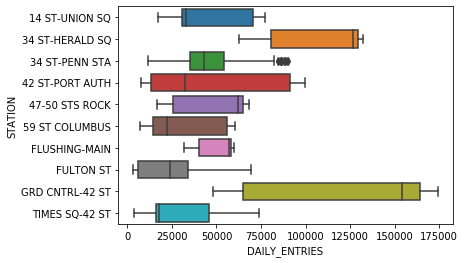

In [65]:
# use seaborn to create a boxplot by station
# with countermax set to 10000000
sns.boxplot('DAILY_ENTRIES', 'STATION', data=stations_daily_top10)

In [66]:
updated_top_stations = {}